In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
from sklearn import metrics

import stellargraph as sg
from stellargraph import StellarGraph
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import DeepGraphCNN

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping

from imblearn.under_sampling import CondensedNearestNeighbour, NearMiss, RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from keras.models import load_model

In [11]:
model = load_model('model_20231007_ver02_0.7')

In [4]:
MID_LIST = []

def normalize(X):
    for column in X.columns:
        mid = (X[column].max() + X[column].min()) / 2
        X[column] = (X[column] - mid)  / (X[column].max() - mid)
        MID_LIST.append(mid)

def create_graph_list(X):
    
    graph = []
    
    columns = X.columns.tolist()
    
    # ,['cviec','pxuong']
    relation_ship = [['cviec1','tgian1'],['cviec2','tgian2'],['tuoinghe','A9a','A9b','nampx'],
                      ['hutthuoc','slthuoc'],['tiensuhh','benhhh'],['ho','tdho','tsho'],
                      ['khacdom','loaidom','tdkhacdo'],['khotho','mdkhotho','tdkhotho'],
                      ['daunguc','vitridau','daulan','tcdau','tgdau','ytodau'],
                      ['sutcan','socansut','tgsut'],['fvclt','fev1lt']]
    
    for tmp_i in range(len(relation_ship)):
        for tmp_j in range(len(relation_ship[tmp_i])):
            relation_ship[tmp_i][tmp_j] = columns.index(relation_ship[tmp_i][tmp_j])
    
    for i in tqdm(range(X.shape[0])):
        source = []
        target = []
        value = []
        indexing = []
        
        for j in range (0, X.shape[1]):
            if not np.isnan(X.iloc[i][j]):
                source.append(0)
                target.append(j)
                value.append(X.iloc[i][j])
                indexing.append(j)   
                
        for j in range(len(relation_ship)):
            flg = True
            for xx in relation_ship[j]:
                if np.isnan(X.iloc[i][xx]):
                    flg = False
                    break
            if flg:
                for xx in relation_ship[j]:
                    source.append(relation_ship[j][0])
                    target.append(xx) 
                
        sg_tmp = pd.DataFrame(
            {"source": source, "target": target}
        )
        sg_tmp_data = pd.DataFrame(
            {"value": value}, 
             index = indexing
        )
        
        sg = StellarGraph(sg_tmp_data, sg_tmp)
        graph.append(sg)
        
    return graph

In [5]:
df = pd.read_excel("Main_data_fixed_ver08.xlsx");

100%|██████████████████████████████████████████████████████████████████████████████| 8030/8030 [12:38<00:00, 10.58it/s]


8030/8030 [==============================] - 58s 7ms/step
pre : actual
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
acc: 0.9865504358655044
7922
Thống kê bộ data predict:
Counter({0: 7805, 1: 225})
Thống kê bộ data actual:
Counter({0: 7819, 1: 211})
f1_score: 0.7522935779816514
precision_score: 0.7772511848341233
recall_score: 0.7288888888888889
Confusion Matrix:


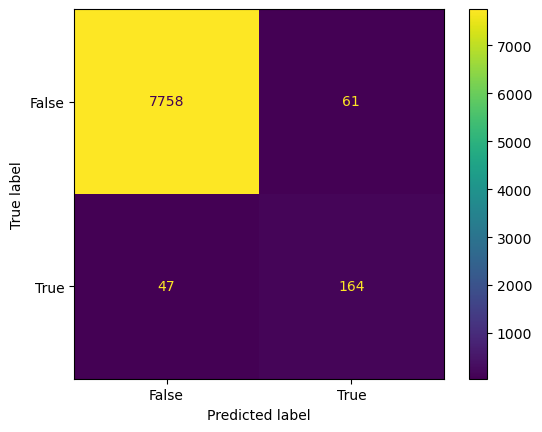

In [7]:
# Test model data real
df_pred_test_ac = df.iloc[:].reset_index(drop=True)

# df_pred_test_ac = df

X_pre_ac = df_pred_test_ac.iloc[:,:-1]
normalize(X_pre_ac)
Y_pre_ac = df_pred_test_ac.iloc[:,-1]

graph_X_ac =  create_graph_list(X_pre_ac)

pre_generator_ac = PaddedGraphGenerator(graphs=graph_X_ac)

t_gen = pre_generator_ac.flow(
    Y_pre_ac.index,
    symmetric_normalization=False,
) 
pre = [round(i[0]) for i in model.predict(t_gen)]
actual = [i for i in Y_pre_ac.values]

counter = 0

print('pre : actual')
for i in range(len(pre)):
    if(counter < 25):
        print(f'{pre[i]}   :   {actual[i]}')
    if pre[i] == actual[i]:
        counter += 1

print(f'acc: {counter/len(pre)}')
print(counter)

from collections import Counter

print("Thống kê bộ data predict:")
print(Counter(pre))
print("Thống kê bộ data actual:")
print(Counter(actual))

print(f'f1_score: {f1_score(pre, actual)}')
print(f'precision_score: {precision_score(pre, actual)}')
print(f'recall_score: {recall_score(pre, actual)}')

print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(actual, pre)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

8030/8030 [==============================] - 60s 8ms/step


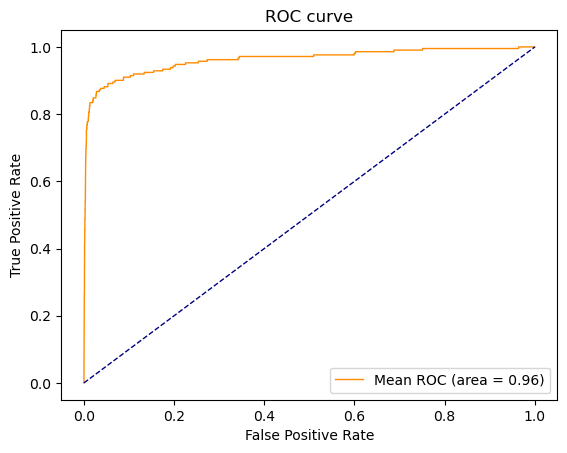

In [8]:
from sklearn.metrics import RocCurveDisplay, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

y_score = [i[0] for i in model.predict(t_gen)]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(actual[:], y_score[:])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(actual, y_score)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 1
plt.plot(
    fpr[1],
    tpr[1],
    color="darkorange",
    lw=lw,
    label="Mean ROC (area = %0.2f)" % roc_auc[1],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.show()

In [13]:
print(classification_report(pre, actual, target_names=['No','Yes'], digits=4))

              precision    recall  f1-score   support

          No     0.9922    0.9940    0.9931      7805
         Yes     0.7773    0.7289    0.7523       225

    accuracy                         0.9866      8030
   macro avg     0.8847    0.8614    0.8727      8030
weighted avg     0.9862    0.9866    0.9863      8030



In [11]:
from sklearn.metrics import auc

print(auc(fpr[1], tpr[1]))

0.9621519824416039


100%|██████████████████████████████████████████████████████████████████████████████| 8030/8030 [13:21<00:00, 10.01it/s]


8030/8030 [==============================] - 58s 7ms/step
pre : actual
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
acc: 0.9865504358655044
7922
Thống kê bộ data predict:
Counter({0: 7805, 1: 225})
Thống kê bộ data actual:
Counter({0: 7819, 1: 211})
f1_score: 0.7522935779816514
precision_score: 0.7772511848341233
recall_score: 0.7288888888888889
Confusion Matrix:


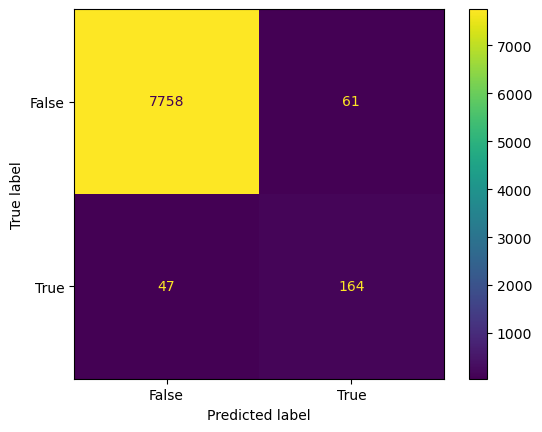

In [12]:
# model = load_model('model_20230921_ver02_0.99')

# Test model data real
df_pred_test_ac = df.iloc[:].reset_index(drop=True)

# df_pred_test_ac = df

X_pre_ac = df_pred_test_ac.iloc[:,:-1]
normalize(X_pre_ac)
Y_pre_ac = df_pred_test_ac.iloc[:,-1]

graph_X_ac =  create_graph_list(X_pre_ac)

pre_generator_ac = PaddedGraphGenerator(graphs=graph_X_ac)

t_gen = pre_generator_ac.flow(
    Y_pre_ac.index,
    symmetric_normalization=False,
) 
pre = [round(i[0]) for i in model.predict(t_gen)]
actual = [i for i in Y_pre_ac.values]

counter = 0

print('pre : actual')
for i in range(len(pre)):
    if(counter < 25):
        print(f'{pre[i]}   :   {actual[i]}')
    if pre[i] == actual[i]:
        counter += 1

print(f'acc: {counter/len(pre)}')
print(counter)

from collections import Counter

print("Thống kê bộ data predict:")
print(Counter(pre))
print("Thống kê bộ data actual:")
print(Counter(actual))

print(f'f1_score: {f1_score(pre, actual)}')
print(f'precision_score: {precision_score(pre, actual)}')
print(f'recall_score: {recall_score(pre, actual)}')

print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(actual, pre)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()